In [1]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time
import pandas as pd
#셀레니엄 예외처리용
from selenium.common.exceptions import ElementClickInterceptedException, NoSuchElementException, ElementNotInteractableException  #(클릭시 없을때, 엘리멘트 자체가 없을떄, 엘리멘트가 상호작용을 못할때 )
import os #이미지 파일 다운로드 제어 용
import socket #소켓 에러 방지용
from urllib.request import urlretrieve #이미지 다운로드 라이브러리
from urllib.error import HTTPError, URLError #각종 에러 방지 라이브러리 (HTTP/URL 에러 방지)
from PIL import Image # 이미지를 사용가능하도록 처리 하는 라이브러리



#웹브라우저를 띄우지 않고 진행하기 위한 설정
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

### scroll_down(): 스크롤을 내리는 함수

In [2]:
def scroll_down():
    scroll_count = 0
    print('[scroll_down() 함수 시작!]')
    
    #스크롤을 내릴려면 위치값이 필요하다. 'execute_script()' 를 통해 스크롤 위치값(Height)을 가져 올 수 있음
    last_height = wd.execute_script("return document.body.scrollHeight")
    after_click = False #스크롤을 계속내리다가 '더 보기'가 나오는지 체크용
    
    
    while True:
        print(f"[스크롤 다운 중: {scroll_count}]")
        # 'scrollTo()' 함수를 써서 0부터 최대 위치값까지 스크롤을 함
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        scroll_count += 1 #스크롤이 최대로 갈때마다 카운트
        time.sleep(1) #JS 액션이 실행되고 반응이 될때까지 기다릴 시간
        
        new_height = wd.execute_script("return document.body.scrollHeight") # 최대값에 도달하면 스크롤이 다시 생성되니 거기서 다시 최대값 구함
        
        if last_height == new_height: #스크롤이 더이상 되지 않다면
            if after_click is True: #'더 보기'가 나온다면..
                break
            else:
                try:
                    more_button = wd.find_element(By.XPATH, '//*[@id="islmp"]/div/div/div/div[1]/div[2]/div[2]/input')
                    if more_button.is_displayed(): # '더 보기' 버튼이 나오면
                        more_button.click()
                        time.sleep(1)
                        after_click = True
                except NoSuchElementException as e:
                    print(e)
                    break
                    
        last_height = new_height    

### click_and_save(): 썸네일 이미지 선택 후 원본 이미지 저장

In [3]:
def click_and_save(dir_name, index, img, img_list_length):
    global scraped_count
    
    try:
        img.click() #이미지를 클릭
        wd.implicitly_wait(5) #클릭 후 로드 시간이 필요하므로 대기
        src = wd.find_element(By.XPATH, '//*[@id="Sva75c"]/div/div/div[3]/div[2]/c-wiz/div/div[1]/div[1]/div[2]/div/a/img').get_attribute('src')
        if src.split('.')[-1] == 'png':
            urlretrieve(src, dir_name + '/' + str(scraped_count + 1) + '.png')
            print(f' {index+1} / {img_list_length} PNG 이미지 저장 완료!')
        else:
            urlretrieve(src, dir_name + '/' + str(scraped_count + 1) + '.jpg')
            print(f' {index+1} / {img_list_length} JPG 이미지 저장 완료!')

        scraped_count += 1
    
    except HTTPError as e:
        print(e)
        pass #PNG, JPG 이외는 다 제외
    except ElementClickInterceptedException as e: # 클릭시 문제 발생하면 아래로
        print(e)
        pass
    

### scraping(): 구글 이미지 스크래핑 함수

In [4]:
def scraping(dir_name, query):
    global scraped_count
    
    url = f'https://www.google.com/search?q={query}&tbm=isch&hl=en&tbs=isz:l&rlz=1C1CHZN_koKR971KR971&sa=X&ved=0CAIQpwVqFwoTCIC5mMe9qfUCFQAAAAAdAAAAABAC&biw=942&bih=941'
    wd.get(url)
    wd.maximize_window() #전체화면으로 스크래핑
    
    scroll_down()
    
    div = wd.find_element(By.XPATH, '//*[@id="islrg"]/div[1]')
    img_list = div.find_elements(By.CSS_SELECTOR, 'div.bRMDJf.islir > img')
#     print(img_list)
    
    for index, img in enumerate(img_list):
        try:
            #이 함수로 저장 이름, 인덱스, 이미지, 이미지 총 개수를 파라미터로 넘긴다
            click_and_save(dir_name, index, img, len(img_list))
        except ElementClickInterceptedException as e: # 클릭시 문제 발생하면 아래로
            print(e)
            wd.execute_script("window.scrllTo(0, window.scrollY + 100)") #스크롤을 다시 하도록
            time.sleep(1)
            click_and_save(dir_name, index, img, len(img_list))
        except NoSuchElementException as e:
            print(e)
            wd.execute_script("window.scrllTo(0, window.scrollY + 100)") #스크롤을 다시 하도록
            time.sleep(1)
            click_and_save(dir_name, index, img, len(img_list))
        except ConnectionResetError as e: #연결 문제는 pass
            print(e)
            pass
        except URLError as e: #URL 문제시 PASS
            print(e)
            pass
        except socket.timeout as e: #소켓 통신 에러 pass
            print(e)
            pass
        except soket.gaierror as e: #소켓 통신 address 에러시 pass
            print(e)
            pass
        except ElementNotInteractableException as e: #엘리멘트 호환이 되지 않을때 
            print(e)
            break
            
    try:
        print("[스크래핑 종료 (성공률: %.2f%%)]" % (scraped_count / len(img_list) * 100.0))
    except ZeroDivisionError as e: #성공률 계산시 0이 나오면 패스
        print(e)
        pass
    
    wd.quit()
    
    

### filter_and_remove(): 일정 해상도 이하이거나 손상된 이미지 제거

In [5]:
def filter_and_remove(dir_name, query, filter_size):
    filtered_count = 0
    for index, file_name in enumerate(os.listdir(dir_name)): #os.listdir = ()의 모든 파일 리스트를 가져 온다
        try:
            file_path = os.path.join(dir_name, file_name) #디렉토리 이름 + 파일 이름 = full path
            img = Image.open(file_path) #풀 패스로 접근해서 하니씩 열도록 세팅 (.image())

            if img.width < filter_size and img.height < filter_size:
                img.close()
                os.remove(file_path) # 필터 사이즈 값보다 작으면 그 위치의 파일을 삭제
                print(f"{index} 이미지 제거")
                filtered_count += 1
        except OSError as e:
            print(e)
            os.remove(file_path) #OS 에러 (안열리거나, 파일손상시 제거)
            filtered_count += 1
    print(f"[이미지 제거 개수: {filtered_count}/{scraped_count}]")

검색어 입력: pepto
[./pepto 디렉토리 생성]
[scroll_down() 함수 시작!]
[스크롤 다운 중: 0]
[스크롤 다운 중: 1]
[스크롤 다운 중: 2]
[스크롤 다운 중: 3]
[스크롤 다운 중: 4]
[스크롤 다운 중: 5]
[스크롤 다운 중: 6]
[스크롤 다운 중: 7]
Message: element click intercepted: Element  is not clickable at point (119, 95). Other element would receive the click: <a href="/search?q=pepto&amp;tbm=isch&amp;hl=en&amp;chips=q:pepto,g_1:pink:BNFn9iqK95U%3D&amp;bih=941&amp;biw=942&amp;rlz=1C1CHZN_koKR971KR971&amp;sa=X&amp;ved=2ahUKEwjzstKhp6v1AhWQFaYKHWkDAqgQ4lYoAHoECAEQGg" data-navigation="server" jslog="11106" aria-label="pink" class="F9PbJd xKddTc">...</a>
  (Session info: headless chrome=97.0.4692.71)
Stacktrace:
Backtrace:
	Ordinal0 [0x00AEFDC3+2555331]
	Ordinal0 [0x00A877F1+2127857]
	Ordinal0 [0x00982E08+1060360]
	Ordinal0 [0x009B48CF+1263823]
	Ordinal0 [0x009B2B10+1256208]
	Ordinal0 [0x009B076B+1247083]
	Ordinal0 [0x009AF559+1242457]
	Ordinal0 [0x009A4FB3+1200051]
	Ordinal0 [0x009C7B0C+1342220]
	Ordinal0 [0x009A4984+1198468]
	Ordinal0 [0x009C7C14+1342484]
	Ordi
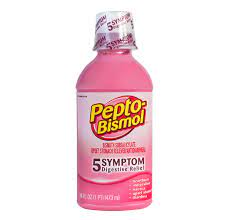

Message: element click intercepted: Element  is not clickable at point (331, 95). Other element would receive the click: <a href="/search?q=pepto&amp;tbm=isch&amp;hl=en&amp;chips=q:pepto,g_1:bismol:AybTl85Fq4E%3D&amp;bih=941&amp;biw=942&amp;rlz=1C1CHZN_koKR971KR971&amp;sa=X&amp;ved=2ahUKEwjzstKhp6v1AhWQFaYKHWkDAqgQ4lYoAnoECAEQHg" data-navigation="server" jslog="11106" aria-label="bismol" class="F9PbJd xKddTc">...</a>
  (Session info: headless chrome=97.0.4692.71)
Stacktrace:
Backtrace:
	Ordinal0 [0x00AEFDC3+2555331]
	Ordinal0 [0x00A877F1+2127857]
	Ordinal0 [0x00982E08+1060360]
	Ordinal0 [0x009B48CF+1263823]
	Ordinal0 [0x009B2B10+1256208]
	Ordinal0 [0x009B076B+1247083]
	Ordinal0 [0x009AF559+1242457]
	Ordinal0 [0x009A4FB3+1200051]
	Ordinal0 [0x009C7B0C+1342220]
	Ordinal0 [0x009A4984+1198468]
	Ordinal0 [0x009C7C14+1342484]
	Ordinal0 [0x009D75FA+1406458]
	Ordinal0 [0x009C7976+1341814]
	Ordinal0 [0x009A36B6+1193654]
	Ordinal0 [0x009A4546+1197382]
	GetHandleVerifier [0x00C89622+1619522]
	Get
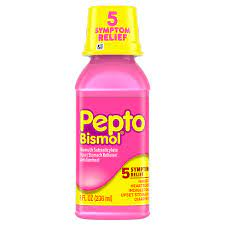

Message: element click intercepted: Element  is not clickable at point (580, 95). Other element would receive the click: <a href="/search?q=pepto&amp;tbm=isch&amp;hl=en&amp;chips=q:pepto,g_1:chewable:JNqsHP7_O_Q%3D&amp;bih=941&amp;biw=942&amp;rlz=1C1CHZN_koKR971KR971&amp;sa=X&amp;ved=2ahUKEwjzstKhp6v1AhWQFaYKHWkDAqgQ4lYoBHoECAEQIg" data-navigation="server" jslog="11106" aria-label="chewable" class="F9PbJd xKddTc">...</a>
  (Session info: headless chrome=97.0.4692.71)
Stacktrace:
Backtrace:
	Ordinal0 [0x00AEFDC3+2555331]
	Ordinal0 [0x00A877F1+2127857]
	Ordinal0 [0x00982E08+1060360]
	Ordinal0 [0x009B48CF+1263823]
	Ordinal0 [0x009B2B10+1256208]
	Ordinal0 [0x009B076B+1247083]
	Ordinal0 [0x009AF559+1242457]
	Ordinal0 [0x009A4FB3+1200051]
	Ordinal0 [0x009C7B0C+1342220]
	Ordinal0 [0x009A4984+1198468]
	Ordinal0 [0x009C7C14+1342484]
	Ordinal0 [0x009D75FA+1406458]
	Ordinal0 [0x009C7976+1341814]
	Ordinal0 [0x009A36B6+1193654]
	Ordinal0 [0x009A4546+1197382]
	GetHandleVerifier [0x00C89622+1619522]

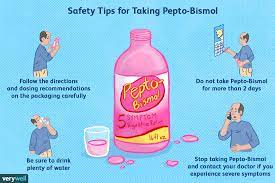

Message: element click intercepted: Element  is not clickable at point (751, 95). Other element would receive the click: <svg viewBox="0 0 24 24" focusable="false" class="dyAbMb">...</svg>
  (Session info: headless chrome=97.0.4692.71)
Stacktrace:
Backtrace:
	Ordinal0 [0x00AEFDC3+2555331]
	Ordinal0 [0x00A877F1+2127857]
	Ordinal0 [0x00982E08+1060360]
	Ordinal0 [0x009B48CF+1263823]
	Ordinal0 [0x009B2B10+1256208]
	Ordinal0 [0x009B076B+1247083]
	Ordinal0 [0x009AF559+1242457]
	Ordinal0 [0x009A4FB3+1200051]
	Ordinal0 [0x009C7B0C+1342220]
	Ordinal0 [0x009A4984+1198468]
	Ordinal0 [0x009C7C14+1342484]
	Ordinal0 [0x009D75FA+1406458]
	Ordinal0 [0x009C7976+1341814]
	Ordinal0 [0x009A36B6+1193654]
	Ordinal0 [0x009A4546+1197382]
	GetHandleVerifier [0x00C89622+1619522]
	GetHandleVerifier [0x00D3882C+2336844]
	GetHandleVerifier [0x00B823E1+541697]
	GetHandleVerifier [0x00B81443+537699]
	Ordinal0 [0x00A8D18E+2150798]
	Ordinal0 [0x00A91518+2168088]
	Ordinal0 [0x00A91660+2168416]
	Ordinal0 [0x00A9B330+220
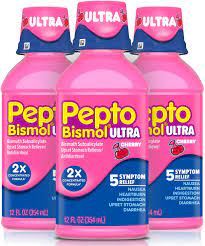

 5 / 434 JPG 이미지 저장 완료!
 6 / 434 JPG 이미지 저장 완료!
 7 / 434 JPG 이미지 저장 완료!
 8 / 434 JPG 이미지 저장 완료!
 9 / 434 JPG 이미지 저장 완료!
 10 / 434 JPG 이미지 저장 완료!
 11 / 434 JPG 이미지 저장 완료!
 12 / 434 JPG 이미지 저장 완료!
 13 / 434 JPG 이미지 저장 완료!
 14 / 434 JPG 이미지 저장 완료!
 15 / 434 JPG 이미지 저장 완료!
 16 / 434 JPG 이미지 저장 완료!
 17 / 434 JPG 이미지 저장 완료!
 18 / 434 JPG 이미지 저장 완료!
 19 / 434 JPG 이미지 저장 완료!
 20 / 434 JPG 이미지 저장 완료!
 21 / 434 JPG 이미지 저장 완료!
 22 / 434 JPG 이미지 저장 완료!
 23 / 434 JPG 이미지 저장 완료!
 24 / 434 JPG 이미지 저장 완료!
 25 / 434 JPG 이미지 저장 완료!
 26 / 434 JPG 이미지 저장 완료!
 27 / 434 JPG 이미지 저장 완료!
 28 / 434 JPG 이미지 저장 완료!
 29 / 434 JPG 이미지 저장 완료!
 30 / 434 JPG 이미지 저장 완료!
 31 / 434 JPG 이미지 저장 완료!
 32 / 434 JPG 이미지 저장 완료!
 33 / 434 JPG 이미지 저장 완료!
 34 / 434 JPG 이미지 저장 완료!
 35 / 434 JPG 이미지 저장 완료!
 36 / 434 JPG 이미지 저장 완료!
 37 / 434 JPG 이미지 저장 완료!
 38 / 434 JPG 이미지 저장 완료!
 39 / 434 JPG 이미지 저장 완료!
 40 / 434 JPG 이미지 저장 완료!
 41 / 434 JPG 이미지 저장 완료!
 42 / 434 JPG 이미지 저장 완료!
 43 / 434 JPG 이미지 저장 완료!
 44 / 434 JPG 이미지 저장 완료!
 45 /

 136 / 434 JPG 이미지 저장 완료!
 137 / 434 JPG 이미지 저장 완료!
 138 / 434 JPG 이미지 저장 완료!
 139 / 434 JPG 이미지 저장 완료!
 140 / 434 JPG 이미지 저장 완료!
 141 / 434 JPG 이미지 저장 완료!
 142 / 434 JPG 이미지 저장 완료!
 143 / 434 JPG 이미지 저장 완료!
 144 / 434 JPG 이미지 저장 완료!
 145 / 434 JPG 이미지 저장 완료!
 146 / 434 JPG 이미지 저장 완료!
 147 / 434 JPG 이미지 저장 완료!
 148 / 434 JPG 이미지 저장 완료!
 149 / 434 JPG 이미지 저장 완료!
 150 / 434 JPG 이미지 저장 완료!
 151 / 434 JPG 이미지 저장 완료!
 152 / 434 JPG 이미지 저장 완료!
 153 / 434 JPG 이미지 저장 완료!
 154 / 434 JPG 이미지 저장 완료!
 155 / 434 JPG 이미지 저장 완료!
 156 / 434 JPG 이미지 저장 완료!
 157 / 434 JPG 이미지 저장 완료!
 158 / 434 JPG 이미지 저장 완료!
 159 / 434 JPG 이미지 저장 완료!
 160 / 434 JPG 이미지 저장 완료!
 161 / 434 JPG 이미지 저장 완료!
 162 / 434 JPG 이미지 저장 완료!
 163 / 434 JPG 이미지 저장 완료!
 164 / 434 JPG 이미지 저장 완료!
 165 / 434 JPG 이미지 저장 완료!
 166 / 434 JPG 이미지 저장 완료!
 167 / 434 JPG 이미지 저장 완료!
 168 / 434 JPG 이미지 저장 완료!
 169 / 434 JPG 이미지 저장 완료!
 170 / 434 JPG 이미지 저장 완료!
 171 / 434 JPG 이미지 저장 완료!
 172 / 434 JPG 이미지 저장 완료!
 173 / 434 JPG 이미지 저장 완료!
 174 / 434 J

 274 / 434 JPG 이미지 저장 완료!
Message: element click intercepted: Element <img data-ils="4" jsaction="rcuQ6b:trigger.M8vzZb;" class="rg_i Q4LuWd" jsname="Q4LuWd" width="223" height="223" alt="Pepto Max By National Stetic Mesotherapy - Mesoterapia – Mesotherapy Store" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQpAQx036tZ5IJeKexlIeG0JSDUzSt6ih7f2Q&amp;usqp=CAU"> is not clickable at point (139, 558). Other element would receive the click: <div jsname="r5xl4" class="islrc" style="width: 440px;">...</div>
  (Session info: headless chrome=97.0.4692.71)
Stacktrace:
Backtrace:
	Ordinal0 [0x00AEFDC3+2555331]
	Ordinal0 [0x00A877F1+2127857]
	Ordinal0 [0x00982E08+1060360]
	Ordinal0 [0x009B48CF+1263823]
	Ordinal0 [0x009B2B10+1256208]
	Ordinal0 [0x009B076B+1247083]
	Ordinal0 [0x009AF559+1242457]
	Ordinal0 [0x009A4FB3+1200051]
	Ordinal0 [0x009C7B0C+1342220]
	Ordinal0 [0x009A4984+1198468]
	Ordinal0 [0x009C7C14+1342484]
	Ordinal0 [0x009D75FA+1406458]
	Ordinal0 [0x009C7976+1341814]
	Ordinal0

 376 / 434 JPG 이미지 저장 완료!
 377 / 434 JPG 이미지 저장 완료!
 378 / 434 JPG 이미지 저장 완료!
 379 / 434 JPG 이미지 저장 완료!
 380 / 434 JPG 이미지 저장 완료!
 381 / 434 JPG 이미지 저장 완료!
 382 / 434 JPG 이미지 저장 완료!
 383 / 434 JPG 이미지 저장 완료!
 384 / 434 JPG 이미지 저장 완료!
 385 / 434 JPG 이미지 저장 완료!
 386 / 434 JPG 이미지 저장 완료!
 387 / 434 JPG 이미지 저장 완료!
 388 / 434 JPG 이미지 저장 완료!
 389 / 434 JPG 이미지 저장 완료!
 390 / 434 JPG 이미지 저장 완료!
 391 / 434 JPG 이미지 저장 완료!
 392 / 434 JPG 이미지 저장 완료!
 393 / 434 JPG 이미지 저장 완료!
 394 / 434 JPG 이미지 저장 완료!
 395 / 434 JPG 이미지 저장 완료!
 396 / 434 JPG 이미지 저장 완료!
 397 / 434 JPG 이미지 저장 완료!
 398 / 434 JPG 이미지 저장 완료!
 399 / 434 JPG 이미지 저장 완료!
 400 / 434 JPG 이미지 저장 완료!
 401 / 434 JPG 이미지 저장 완료!
 402 / 434 JPG 이미지 저장 완료!
HTTP Error 403: Forbidden
 404 / 434 JPG 이미지 저장 완료!
 405 / 434 JPG 이미지 저장 완료!
 406 / 434 JPG 이미지 저장 완료!
 407 / 434 JPG 이미지 저장 완료!
 408 / 434 JPG 이미지 저장 완료!
 409 / 434 JPG 이미지 저장 완료!
 410 / 434 JPG 이미지 저장 완료!
 411 / 434 JPG 이미지 저장 완료!
 412 / 434 JPG 이미지 저장 완료!
 413 / 434 JPG 이미지 저장 완료!
Message: ele

In [6]:
socket.setdefaulttimeout(30)#소켓 통신 시간 제어

wd = webdriver.Chrome('chromedriver', options=chrome_options)

scraped_count = 0 #이미지 스크래핑 개수 카운트 용

path = './' #현재 사용하는 위치에서 검색어 폴더를 만들고 이미지 다운로드 용
query = input('검색어 입력: ')

dir_name = path + query
os.makedirs(dir_name) # 'dir_name' 으로 폴더 생성

print(f"[{dir_name} 디렉토리 생성]")

scraping(dir_name, query)

filter_and_remove(dir_name, query, 400)